In [1]:
import sys
sys.path.append('../../VQC-Lite')
from IPython.display import Image
from IPython.display import HTML
HTML(open('stylesheet.css').read())

# Experiments with VQC
Author: Kevin Shen (www.linkedin.com/in/kevinshen-tum) 

In this notebook, we will introduce some basic experiments with VQC. In the first part, we will show how to evaluate the expressibility of a VQC. In the second part, we will demonstrate how one may compress and prepare an image as a quantum state and then upload it onto a quantum computer. For more details please refer to the documentation.

## Expressibility
<div class=Des> Expressibility is a popular descriptor of VQCs. To compute the expressibility, one would randomly sample pairs of parameters from the parameter space and compute the fidelity between the output statevectors from the VQC. The resultant distribution is then compared with that of comparing pairs of Haar random states from the corresponding Hilbert space. Expressibility is defined as the KL-divergence between the two distributions. 
    
For more details, please refer to the paper: "Expressibility and entangling capability of parameterized quantum circuits for hybrid quantum-classical algorithms". S. Sim et al. arXiv: 1905.10876

In [2]:
import numpy as np
from circuit_stack_pennylane.circuit_mps import MPS_GU2_P
from experiments.expressibility import Expressibility_Evaluation

In [3]:
circuit = MPS_GU2_P(nl=1, nq=4)

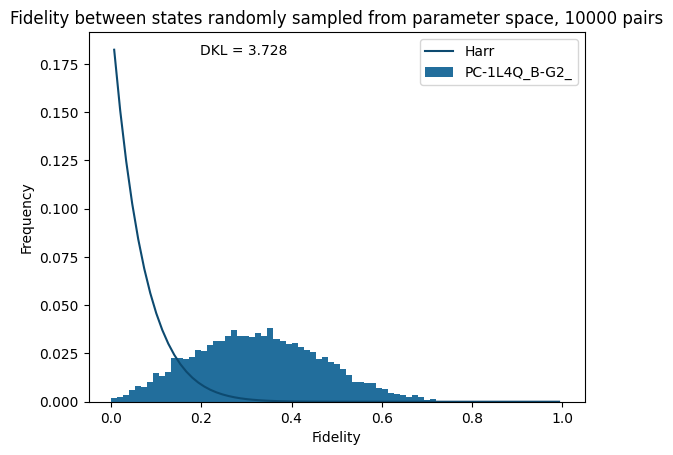

In [4]:
task = Expressibility_Evaluation(circuit)
task.run()

## Uploading an Image onto a Quantum Computer
<div class=Des> Upload an image onto a quantum computer takes 3 steps. 
    
1. Define a mapping between the image data and target quantum state.
2. Define a VQC to (approximately) prepare the quantum state.
3. Optimize the VQC to determine the gate parameters.
    
The states we aim to prepare are called flexible representation of quantum images (FRQI). We invite interested readers to read "Data Compression for Quantum Machine Learning" R.Dilip et al. arXiv:2204.11170 and https://qiskit.org/textbook/ch-applications/image-processing-frqi-neqr.html for more details.

In [18]:
import matplotlib.pyplot as plt
from circuit_stack.circuit_mps import MPS_GU2

In [19]:
def frqi_to_image(psi):
    nb = len(psi.shape) - 1
    psi = psi.reshape(int(2**(nb/2)), int(2**(nb/2)), 2)
    psi *= 2**(nb/2)
    psi = np.array(psi)
    psi[1::2, :] = psi[1::2, ::-1]
    data = np.zeros((int((2**(nb/2))), int((2**(nb/2))), 1))
    for i in range(np.shape(data)[0]):
        for j in range(np.shape(data)[1]):
            data[i][j] = np.arccos(min(np.abs(psi[i][j][0]), 1)) * 2 / np.pi
    return data

def plot_image(image):
    fig, ax = plt.subplots(1,1, figsize=(9,3))
    im = ax.imshow(image, cmap='Greys', vmin=0, vmax=+1.)
    ax.figure.colorbar(im)
    plt.show()

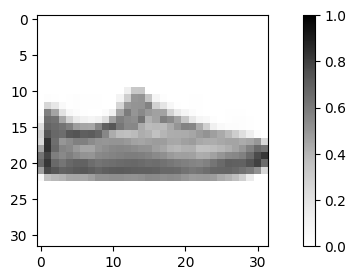

In [20]:
target = np.load('../../demo/sample_data/target.npy')
plot_image(frqi_to_image(target))

<div class=Not> Above is the image we want to prepare.

<div class=Des> Below we define a VQC with 4 layers of general 2 qubit unitaries covering 11 qubits. We can approximate the target state with parameters that we've found from optimzation using Adam optimizer.

In [23]:
circuit = MPS_GU2(nl=4, nq=11)

Input with 600 optimized parameters for the parameterized gates.


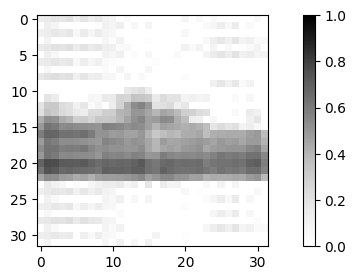

In [36]:
flattened_params = np.load('../../demo/sample_data/adam.npy')
print('Input with', flattened_params.shape[0], 'optimized parameters for the parameterized gates.')
psi1 = circuit.run_with_param_input(flattened_params)
plot_image(frqi_to_image(psi1))

<div class=Des> We can alternatively use a sweeping method to perform the optimization.

Input with 40 optimized parameterized gates, each with shape (2, 2, 2, 2) .


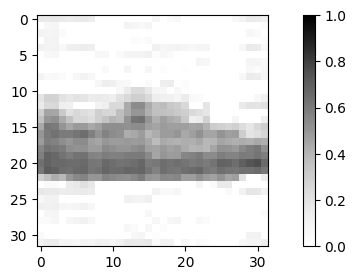

In [38]:
gates = np.load('../../demo/sample_data/sweeping.npy')
print('Input with', gates.shape[0],'optimized parameterized gates, each with shape', gates.shape[1:], '.')
psi2 = circuit.run_with_gate_input(gates)
plot_image(frqi_to_image(psi2))

<div class=Not> Please read the documentation for the file state_preparation.py and see if you could reproduce the results above!